In [1]:
# -*- coding: utf-8 -*-
# @author: tongzi
# @created date: 2019/07/24
# @description: Data Aggregation and Gouping Operations
# @last modification:2019/07/14

In [2]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

Categorizing a dataset and applying a function to each group, whether aggregation or transformation, is often a critical component of a data analysis workflow. After loading, merging, and prepraring a dataset, we may need to compute group statistics or possibly *pivot tables* for reporting or visualization purposes. *pandas* provides a flexible *groupby*() interface, enabling us to slice, dice, and summary dataset in a natural way.

One reason for the popularity of relational databases and SQL (which stands for structured query language) is the ease with whcih data can be joined, filtered, transformed, and aggregated. However, query languages like SQL are somewhat constrained in the kind of group operations that can be performed. As we will see, with the expressiveness of Python and pandas, we can perform quit compplex group operations by utilizing any function that accepts a pandas object or NumPy array. In this chapter,we will learn how to:  
(1)Splits a pandas object into pieces using one or more keys (in the form of functions, arrays, or DataFrame columns)  
  
(2)Calculate group summary statistics, like count, mean, standard deviation or user-defined function  
  
(3)Apply within-group transformation or other manipulations, like normalization, linear regression, rank, or subset selection.  
  
(4)Compute pivot table and cross tabulations  
  
(5)Perform quantile analysis and other statistical analysis.

  
  
  

>Aggregation for time series data, a special case of groupby, is referred to as *resampling*() in this book and will receive treatment in Chapter 11.

### 10.1 GroupBy Mechanics

Hadly Wickham,很多R编程语言流行包的作者，为描述分组操作创造一个术语“split-apply-combine”（分隔，应用，组合）。该过程的第一个阶段中，一个pandas对象中的数据不论是Series，DataFrame或者其它类型的数据会根据一个或者多个提供的键被分割成一个个组。分割操作是在一个对象的某个特定轴进行。比如说，一个DataFrame可以按照行或者列进行分割。分割完成后，每一个组应用一个函数并产生一个新的值。最后，所有应用到每个组的函数的结果组合到一起。组合的结果其形式取决于对数据执行了怎样的操作。如图所示：  
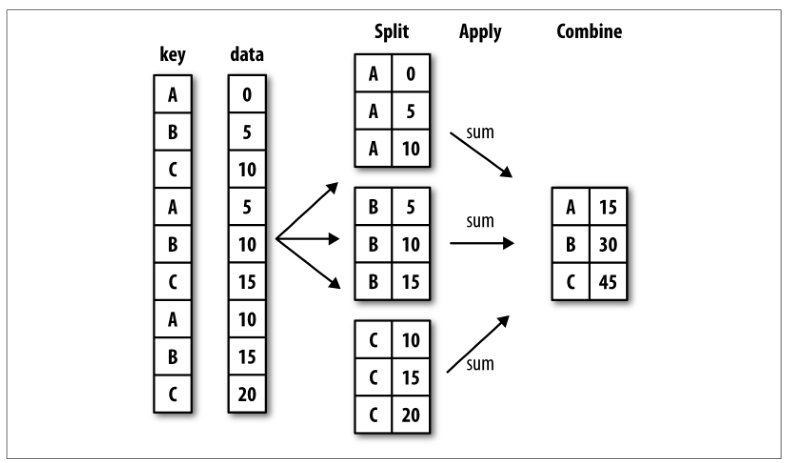

每一个分组的键可以是多种形式的，不一定都是相同的类型：  
（1）一个列表或者数组，其中的值和要被分组的轴在长度是相等的  
（2）DataFrame中的一个列名  
（3）一个字典或者Series，它给出了要给分组的轴的值与该组名字的对应关系  
（4）一个函数，该函数在轴索引或某索引的单个标签上进行调用

In [3]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
....: 'key2' : ['one', 'two', 'one', 'two', 'one'],
....: 'data1' : np.random.randn(5),
....: 'data2' : np.random.randn(5)})

In [4]:
df

,data1,data2,key1,key2
0,-0.617589,-0.374134,a,one
1,0.576959,-0.317123,a,two
2,-0.768091,1.262851,b,one
3,-1.837249,-0.068181,b,two
4,1.111653,1.176868,a,one


Suppose we want to compute the mean of the *data1* using the labels frin *key1*. There are a number of ways to do this, One is to access *data1* and call *groupby*() with the column (a Series) at *key1*: 

In [7]:
grouped = df['data1'].groupby(df['key1'])

In [8]:
grouped

This *grouped* variable is now a GroupBy object. It has not actualy computed anything except for some intermediate data about the group key df['key1']. The idea is that this object has all of the information needed to apply some group operation to each of the groups. For example, to compute group means we can the GoupBy's *mean*() method:

In [9]:
grouped.mean()

key1
a    0.357008
b   -1.302670
Name: data1, dtype: float64

Later, we will explain more about what happens when we call *.mean*(). The important thing here is that the data (Series) has been aggregated according to the group key, producing a new Series that is now indexed by the unique values in the *key1* column.  
  
The result index has the name 'key1' because the DataFrame column df['key1'] did.  
  
If instead we had passed multiple arrays as a list, we'd get something different:

In [11]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()

In [12]:
means

key1  key2
a     one     0.247032
      two     0.576959
b     one    -0.768091
      two    -1.837249
Name: data1, dtype: float64

Here we grouped the data using two keys, and the resulting Series has a hierarchical index consisting of the unique pairs of keys observed.

In [13]:
means.unstack()

key2,one,two
key1,,
a,0.247032,0.576959
b,-0.768091,-1.837249


In this example, the group keys are all Series, though they can be any arrays of the right length:

In [14]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])

In [15]:
years = np.array([2005, 2005, 2006, 2005, 2006])

In [16]:
df['data1'].groupby([states, years]).mean()

California  2005    0.576959
            2006   -0.768091
Ohio        2005   -1.227419
            2006    1.111653
Name: data1, dtype: float64

Frequently the grouping information is found in the same DataFrame as the data you work on. In that case, we can pass column names (whether those are strings, numbers, or other Python object) as the group keys:

In [17]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,0.357008,0.161870
b,-1.302670,0.597335


In [18]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one   0.247032  0.401367
     two   0.576959 -0.317123
b    one  -0.768091  1.262851
     two  -1.837249 -0.068181

You may have noticed in the first case *df['key1'].mean*() that there is no *key2* column in the result. Because *df['key2']* is not numeric data, it is said to a *nuisance column* (讨厌的列), which is excluded from the result. By default, all of the numeric columns are aggregated, though it is possible to filter down to a subset, as we'll see soon.

In [19]:
df

,data1,data2,key1,key2
0,-0.617589,-0.374134,a,one
1,0.576959,-0.317123,a,two
2,-0.768091,1.262851,b,one
3,-1.837249,-0.068181,b,two
4,1.111653,1.176868,a,one


Regardless of the objective in using *groupby*(), a generally useful GroupBy method is *size*(), which returns a Series containing group sizes:

In [20]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

>Take note that any missing values in a group key will be excluded from the result.

#### Iterating Over Groups

The GroupBy object supports iteration, generating a sequence of 2-tuples (2元素元组) containing the group name along with the chunk of data. Consider the following:

In [24]:
list(df.groupby('key1'))

[('a',       data1     data2 key1 key2
  0 -0.617589 -0.374134    a  one
  1  0.576959 -0.317123    a  two
  4  1.111653  1.176868    a  one), ('b',       data1     data2 key1 key2
  2 -0.768091  1.262851    b  one
  3 -1.837249 -0.068181    b  two)]

In [25]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

a
      data1     data2 key1 key2
0 -0.617589 -0.374134    a  one
1  0.576959 -0.317123    a  two
4  1.111653  1.176868    a  one
b
      data1     data2 key1 key2
2 -0.768091  1.262851    b  one
3 -1.837249 -0.068181    b  two


In the case of multiple keys, the first element in the tuple will be a tuple of key values:

In [28]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
      data1     data2 key1 key2
0 -0.617589 -0.374134    a  one
4  1.111653  1.176868    a  one
('a', 'two')
      data1     data2 key1 key2
1  0.576959 -0.317123    a  two
('b', 'one')
      data1     data2 key1 key2
2 -0.768091  1.262851    b  one
('b', 'two')
      data1     data2 key1 key2
3 -1.837249 -0.068181    b  two


Of course, we can choose to whateve we want with the pieces of data, A recipe you may find useful is computing a dict of the pieces as one-liner (一行)：

In [30]:
pieces = dict(list(df.groupby('key1')))

In [32]:
pieces['a']

,data1,data2,key1,key2
0,-0.617589,-0.374134,a,one
1,0.576959,-0.317123,a,two
4,1.111653,1.176868,a,one


By default, *groupby*() groups on axis=0, but we can group on any of the  other axes. For example, we could group the columns of our example *df* by **dtype** like so:

In [33]:
df.dtypes

data1    float64
data2    float64
key1      object
key2      object
dtype: object

In [34]:
grouped = df.groupby(df.dtypes, axis=1)

We can print out the groups like so:

In [36]:
for dtype, group in grouped:
    print(dtype)
    print(group)

float64
      data1     data2
0 -0.617589 -0.374134
1  0.576959 -0.317123
2 -0.768091  1.262851
3 -1.837249 -0.068181
4  1.111653  1.176868
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


#### Selecting a Column or Subset of Columns

Indexing a GroupBy object created from a DataFrame with a column name or array of column names has the effect of column subsetting for aggregation. This means that:

&emsp;&emsp;*df.groupby('key1')['data1']*   
&emsp;&emsp;*df.groupby('key1')[['data2']]*

are syntactic sugar for:

&emsp;&emsp;*df['data1'].groupby(df['key1'])*  
&emsp;&emsp;*df[['data2']].groupby(df['key2'])*

In [42]:
df['data2'] # 这种方式会返回一个Series对象

0   -0.374134
1   -0.317123
2    1.262851
3   -0.068181
4    1.176868
Name: data2, dtype: float64

In [43]:
df[['data2']] # 这种方式会返回一个DataFrame对象

,data2
0,-0.374134
1,-0.317123
2,1.262851
3,-0.068181
4,1.176868


对于大的数据集，可能指向聚合一列数据，比方说，在前面的数据集中，只想计算*data2*列的均值，并且其结果作为一个DataFrame返回，可以写：

In [46]:
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one   0.401367
     two  -0.317123
b    one   1.262851
     two  -0.068181

The object returned by this indexing operation is a grouped DataFrame if a list or array is passed or a grouped Series if only a single column name is passed as a scalar:

In [47]:
s_grouped = df.groupby(['key1', 'key2'])['data2']

In [48]:
s_grouped

In [49]:
s_grouped.mean()

key1  key2
a     one     0.401367
      two    -0.317123
b     one     1.262851
      two    -0.068181
Name: data2, dtype: float64

#### Grouping with Dicts and Series

In [50]:
people = pd.DataFrame(np.random.randn(5, 5),
....: columns=['a', 'b', 'c', 'd', 'e'],
....: index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])

In [52]:
people.iloc[2:3, [1,2]] = np.nan

In [53]:
people

,a,b,c,d,e
Joe,1.694863,-0.859252,-0.378582,1.299047,0.308418
Steve,0.390051,0.050784,0.113605,0.738955,0.591038
Wes,1.928222,NaN,NaN,-0.744453,3.587657
Jim,-0.264488,0.369377,-0.680568,-1.039184,0.772989
Travis,-1.011185,-1.567022,0.751634,1.627954,-2.167620


Now, suppose I have a group correspondence for the columns and want to sum together the columns by group:

In [54]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
....: 'd': 'blue', 'e': 'red', 'f' : 'orange'}

Now we can construct an array from this dict to pass to *groupby*(), but instead we can just the dict (I included the key *'f'* to highlight that unused grouping keys are OK):

In [55]:
by_column = people.groupby(mapping, axis=1)

In [57]:
by_column.sum()

,blue,red
Joe,0.920465,1.144029
Steve,0.852560,1.031873
Wes,-0.744453,5.515879
Jim,-1.719752,0.877877
Travis,2.379588,-4.745827


The same functionality holds for Series, which can be viewed as a fix-size mapping:

In [59]:
map_series = pd.Series(mapping)

In [60]:
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [61]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


Using Python function is a more generic way of defining a group mapping compared with a dict or Series. **Any function passed as group key will be called once per index value, with the returned values being used as the group names.** More concretely, consider the example DataFrame from the previous section, which has people's first names as index values. Suppose we want to group by the lenght of the names; while we could compute an array of string lenghts, it's simpler to just pass the *len*() function:

In [64]:
people.groupby(len).sum()

,a,b,c,d,e
3,3.358597,-0.489876,-1.059150,-0.484590,4.669064
5,0.390051,0.050784,0.113605,0.738955,0.591038
6,-1.011185,-1.567022,0.751634,1.627954,-2.167620


In [67]:
list(people.groupby(len))

[(3,             a         b         c         d         e
  Joe  1.694863 -0.859252 -0.378582  1.299047  0.308418
  Wes  1.928222       NaN       NaN -0.744453  3.587657
  Jim -0.264488  0.369377 -0.680568 -1.039184  0.772989),
 (5,               a         b         c         d         e
  Steve  0.390051  0.050784  0.113605  0.738955  0.591038),
 (6,                a         b         c         d        e
  Travis -1.011185 -1.567022  0.751634  1.627954 -2.16762)]

Mixing function with dicts, arrays or Series is not a problem as evething gets converted to array internally:

In [65]:
key_list = ['one', 'one', 'one', 'two', 'two']

In [75]:
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one  1.694863 -0.859252 -0.378582 -0.744453  0.308418
  two -0.264488  0.369377 -0.680568 -1.039184  0.772989
5 one  0.390051  0.050784  0.113605  0.738955  0.591038
6 two -1.011185 -1.567022  0.751634  1.627954 -2.167620

In [74]:
list(people.groupby(key_list))

[('one',               a         b         c         d         e
  Joe    1.694863 -0.859252 -0.378582  1.299047  0.308418
  Steve  0.390051  0.050784  0.113605  0.738955  0.591038
  Wes    1.928222       NaN       NaN -0.744453  3.587657),
 ('two',                a         b         c         d         e
  Jim    -0.264488  0.369377 -0.680568 -1.039184  0.772989
  Travis -1.011185 -1.567022  0.751634  1.627954 -2.167620)]

In [72]:
people

,a,b,c,d,e
Joe,1.694863,-0.859252,-0.378582,1.299047,0.308418
Steve,0.390051,0.050784,0.113605,0.738955,0.591038
Wes,1.928222,NaN,NaN,-0.744453,3.587657
Jim,-0.264488,0.369377,-0.680568,-1.039184,0.772989
Travis,-1.011185,-1.567022,0.751634,1.627954,-2.167620


#### Grouping by Index Levels

A final convenience for hierarchically indexex datasets is the ability to aggregate using one of the levels of an axis index. Let's look at an example:

In [76]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
....: [1, 3, 5, 1, 3]],
....: names=['cty', 'tenor'])

In [77]:
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)

In [78]:
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0     -0.725503  0.407642  0.263978 -0.029599 -0.995289
1     -0.268026  0.584391  0.281984  0.400324  0.233844
2      0.705353 -0.676956  0.144213 -0.298194 -0.022045
3      0.321843 -1.992313 -0.123888  0.506249 -0.779026

To group by level, pass the level number or name using the *level* keyword:

In [79]:
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3
